<a href="https://colab.research.google.com/github/RickPardono/Sistema-de-recomenda-o-de-livros/blob/main/Versao_Final_Projeto_Aplicado_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install surprise

In [2]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise.accuracy import rmse
from surprise.accuracy import mae
import difflib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ratings_data = pd.read_csv('/content/ratings.csv')
books_metadata = pd.read_csv('/content/books.csv')

In [4]:
ratings_data.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [5]:
ratings_data.shape

(5976479, 3)

In [6]:
ratings_data.isnull().sum()

user_id    0
book_id    0
rating     0
dtype: int64

In [7]:
ratings_data.duplicated().sum()

0

In [8]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


In [9]:
books_metadata.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [10]:
books_metadata.shape

(10000, 23)

In [11]:
books_metadata.isnull().sum()

book_id                         0
goodreads_book_id               0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

In [12]:
books_metadata.duplicated().sum()

0

In [13]:
books_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

In [14]:
# Quantidade total de usuários
ratings_data['user_id'].nunique()

53424

In [15]:
# Quantidade total de livros avaliados
ratings_data['book_id'].nunique()

10000

In [16]:
# Quantidade total de livros
books_metadata['book_id'].nunique()

10000

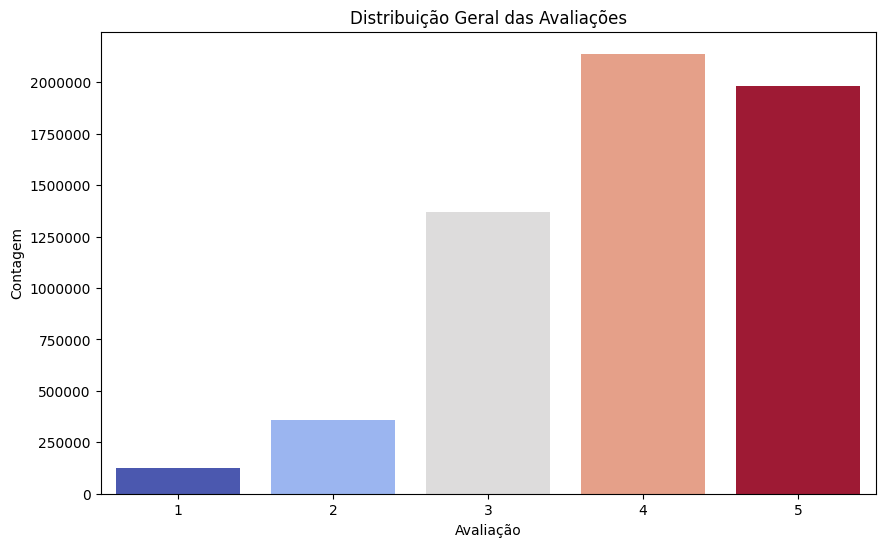

In [17]:
# Criando o gráfico para avaliar distribuição das avaliações
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', hue='rating', data=ratings_data, palette='coolwarm', legend=False)
plt.title('Distribuição Geral das Avaliações')
plt.xlabel('Avaliação')
plt.ylabel('Contagem')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [18]:
# Contagem de avaliações por livro
book_counts = ratings_data['book_id'].value_counts()
# Imprimir estatísticas descritivas
print(book_counts.describe().round(2))

count    10000.00
mean       597.65
std       1267.29
min          8.00
25%        155.00
50%        248.00
75%        503.00
max      22806.00
Name: count, dtype: float64


In [19]:
# Contagem de avaliações por usuário
user_counts = ratings_data['user_id'].value_counts()
# Imprimir estatísticas descritivas
print(user_counts.describe().round(2))

count    53424.00
mean       111.87
std         26.07
min         19.00
25%         96.00
50%        111.00
75%        128.00
max        200.00
Name: count, dtype: float64


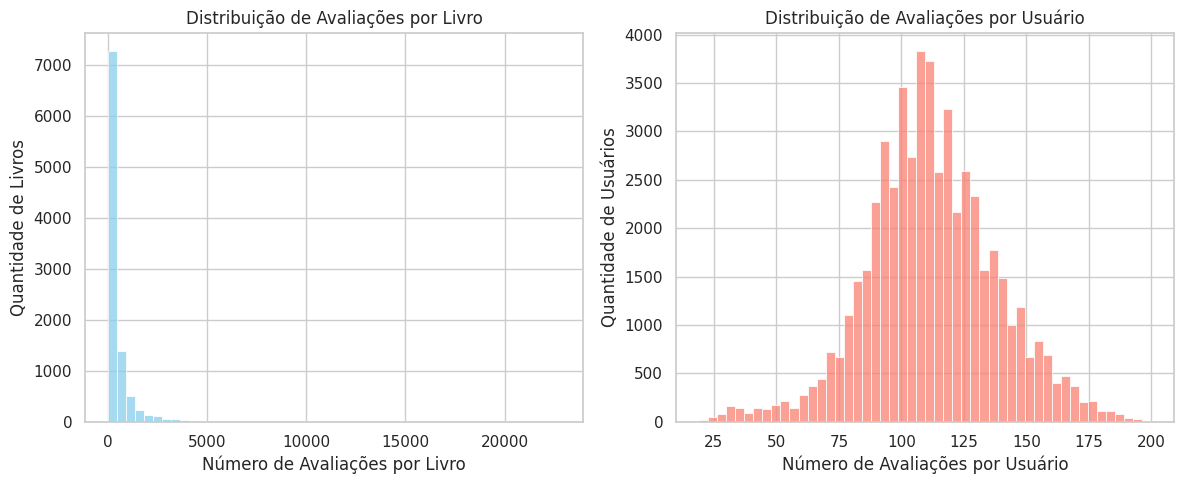

In [20]:
sns.set(style="whitegrid")
# Criação da figura com subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histograma para a distribuição de avaliações por livro
sns.histplot(book_counts, bins=50, color='skyblue', ax=ax[0], kde=False)
ax[0].set_title('Distribuição de Avaliações por Livro')
ax[0].set_xlabel('Número de Avaliações por Livro')
ax[0].set_ylabel('Quantidade de Livros')

# Histograma para a distribuição de avaliações por usuário
sns.histplot(user_counts, bins=50, color='salmon', ax=ax[1], kde=False)
ax[1].set_title('Distribuição de Avaliações por Usuário')
ax[1].set_xlabel('Número de Avaliações por Usuário')
ax[1].set_ylabel('Quantidade de Usuários')

# Ajuste automático do layout para evitar sobreposições
plt.tight_layout()

# Mostra o gráfico
plt.show()

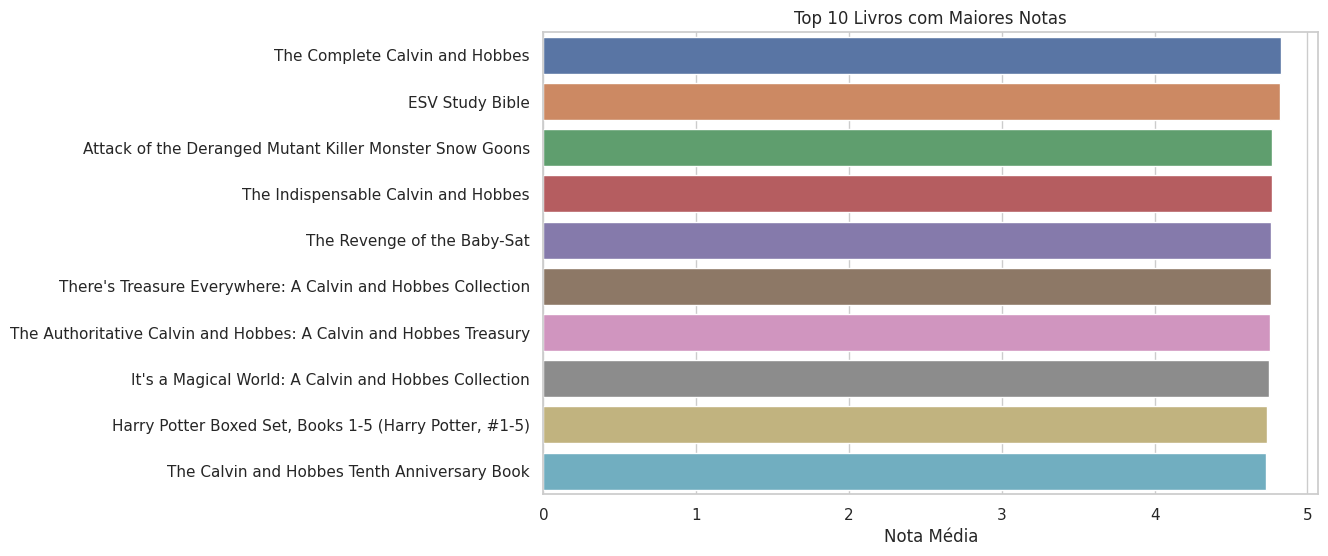

In [21]:
# Calcular a média de avaliação para cada livro
book_avg_ratings = ratings_data.groupby('book_id')['rating'].mean()

# Ordenar os livros pela nota média e selecionar os top 10
top_10_books_ids = book_avg_ratings.nlargest(10).index

# Juntar com os metadados dos livros para obter os títulos dos top 10 livros.
top_10_books_info = books_metadata[books_metadata['book_id'].isin(top_10_books_ids)]
top_10_books_info = top_10_books_info.set_index('book_id').join(book_avg_ratings, on='book_id')
top_10_books_info = top_10_books_info.nlargest(10, 'rating')  # Garantindo que são os top 10 após o join

plt.figure(figsize=(10, 6))
sns.barplot(x='rating', y='title', data=top_10_books_info,hue='title', palette='deep')
plt.title('Top 10 Livros com Maiores Notas')
plt.xlabel('Nota Média')
plt.ylabel('')
plt.show()

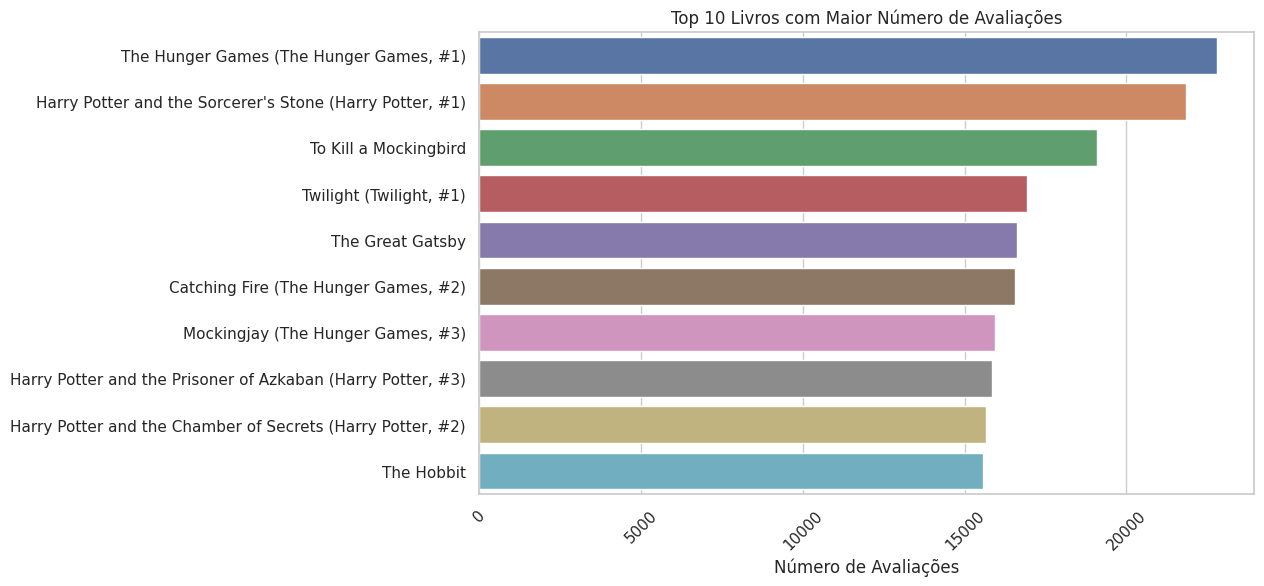

In [22]:
# Contar o número de avaliações por livro
book_ratings_counts = ratings_data.groupby('book_id')['rating'].count()

# Ordenar os livros pelo número de avaliações e selecionar os top 10
top_10_books_ids = book_ratings_counts.nlargest(10).index

# Obter os títulos dos top 10 livros
top_10_books_titles = books_metadata[books_metadata['book_id'].isin(top_10_books_ids)]

# Juntar os títulos com os contagens de avaliações
top_10_books = top_10_books_titles.set_index('book_id').join(book_ratings_counts, on='book_id')
top_10_books = top_10_books.nlargest(10, 'rating')

# Passo 4: Plotar os resultados
plt.figure(figsize=(10, 6))
sns.barplot(x='rating', y='title', data=top_10_books, hue='title', palette='deep')
plt.title('Top 10 Livros com Maior Número de Avaliações')
plt.xlabel('Número de Avaliações')
plt.ylabel('')
plt.xticks(rotation=45)
plt.show()

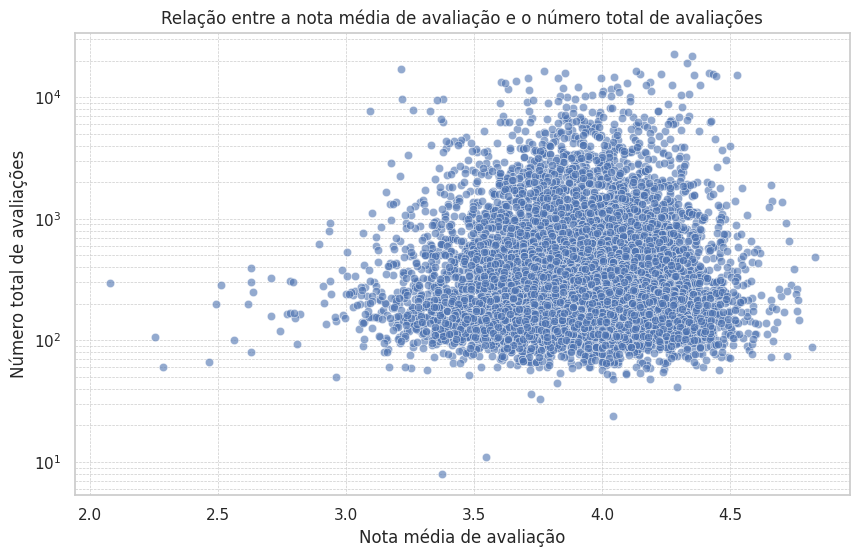

In [23]:
# Calculando a média de avaliação para cada livro
average_ratings = ratings_data.groupby('book_id')['rating'].mean()

# Calculando o número total de avaliações para cada livro
ratings_count = ratings_data.groupby('book_id')['rating'].count()

# Criando um DataFrame com as informações calculadas
books_info = pd.DataFrame({'Average Rating': average_ratings, 'Number of Ratings': ratings_count})

# Criando o scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=books_info, x='Average Rating', y='Number of Ratings', alpha=0.6)

plt.title('Relação entre a nota média de avaliação e o número total de avaliações')
plt.xlabel('Nota média de avaliação')
plt.ylabel('Número total de avaliações')
plt.xscale('linear')
plt.yscale('log')  # Usando escala logarítmica no eixo y para melhor visualização
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

In [24]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings_data[['book_id','user_id','rating']],reader)

In [25]:
# Dividindo os dados em conjuntos de treinamento e teste
trainset, testset = train_test_split(data, test_size=0.25)

In [26]:
svd = SVD(verbose=True, n_epochs=20)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

{'test_rmse': array([0.84094993, 0.83994929, 0.84105262]),
 'test_mae': array([0.65064803, 0.65009086, 0.65098261]),
 'fit_time': (114.89290523529053, 118.51020359992981, 118.0201563835144),
 'test_time': (35.74937343597412, 35.57055068016052, 35.03021597862244)}

In [27]:
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [ ]:
predictions_svd = svd.test(testset)

In [ ]:
# Avaliação de desempenho no conjunto de teste:
rmse = accuracy.rmse(predictions_svd)
mae = accuracy.mae(predictions_svd)

RMSE: 0.8344
MAE:  0.6443


In [ ]:
def get_book_id(book_title, metadata):
    """
    Gets the book ID for a book title based on the closest match in the metadata dataframe.
    """
    existing_titles = list(metadata['title'].values)
    closest_titles = difflib.get_close_matches(book_title, existing_titles)
    book_id = metadata[metadata['title'] == closest_titles[0]]['book_id'].values[0]
    return book_id

In [ ]:
def get_book_info(book_id, metadata):
    """
    Returns some basic information about a book given the book id and the metadata dataframe.
    """
    book_info = metadata[metadata['book_id'] == book_id][['book_id', 'isbn','authors', 'title', 'original_title']]
    return book_info.to_dict(orient='records')

In [ ]:
def predict_review(user_id, book_title, model, metadata):
    """
    Predicts the review (on a scale of 1-5) that a user would assign to a specific book.
    """
    book_id = get_book_id(book_title, metadata)
    review_prediction = model.predict(uid=user_id, iid=book_id)
    return review_prediction.est

In [ ]:
def generate_recommendation(user_id, model, metadata, thresh=4, num_recommendations=3):
    """
    Generates book recommendations for a user based on a rating threshold. Only
    books with a predicted rating at or above the threshold will be recommended.
    This version recommends a specified number of books.

    Args:
    - user_id: The user ID for whom the recommendation is being generated.
    - model: The prediction model.
    - metadata: The dataframe containing book metadata.
    - thresh: The rating threshold above which books are recommended.
    - num_recommendations: The number of recommendations to generate.

    Returns:
    A list of dictionaries, each containing information about a recommended book.
    """
    book_titles = list(metadata['title'].values)
    recommendations = []

    for book_title in book_titles:
        if len(recommendations) >= num_recommendations:
            break
        rating = predict_review(user_id, book_title, model, metadata)
        if rating >= thresh:
            book_id = get_book_id(book_title, metadata)
            book_info = get_book_info(book_id, metadata)
            recommendations.append(book_info[0])

    return recommendations

In [ ]:
# Gerar recomendações para o usuário de ID 1000:
generate_recommendation(1000, svd, books_metadata)

[{'book_id': 2,
  'isbn': '439554934',
  'authors': 'J.K. Rowling, Mary GrandPré',
  'title': "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",
  'original_title': "Harry Potter and the Philosopher's Stone"},
 {'book_id': 5,
  'isbn': '743273567',
  'authors': 'F. Scott Fitzgerald',
  'title': 'The Great Gatsby',
  'original_title': 'The Great Gatsby'},
 {'book_id': 6,
  'isbn': '525478817',
  'authors': 'John Green',
  'title': 'The Fault in Our Stars',
  'original_title': 'The Fault in Our Stars'}]

## **Melhoria no modelo SVD com otimização dos parâmetros do modelo. Isso incluiu ajustar o número de épocas, a taxa de aprendizagem e o termo de regularização:**

In [ ]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings_data[['book_id','user_id','rating']],reader)

In [28]:
# Definição dos parâmetros para o GridSearchCV
param_grid = {
    'n_factors': [100],
    'n_epochs': [20, 30],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]
}

In [29]:
# Configuração do GridSearchCV
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs.fit(data)

In [30]:
# Melhores parâmetros encontrados
print("Melhores parâmetros para RMSE:", gs.best_params['rmse'])
print("Melhores parâmetros para MAE:", gs.best_params['mae'])

Melhores parâmetros para RMSE: {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}
Melhores parâmetros para MAE: {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.02}


In [31]:
# Dividindo os dados em conjuntos de treinamento e teste
trainset, testset = train_test_split(data, test_size=0.25)

In [32]:
# Configurando e treinando o modelo otimizado para RMSE
model_rmse = SVD(n_factors=100, n_epochs=30, lr_all=0.01, reg_all=0.1)
model_rmse.fit(trainset)

In [33]:
# Avaliação do modelo otimizado para RMSE
predictions_rmse = model_rmse.test(testset)
rmse_score = accuracy.rmse(predictions_rmse)

RMSE: 0.8316


In [34]:
# Configurando e treinando o modelo otimizado para MAE
model_mae = SVD(n_factors=100, n_epochs=30, lr_all=0.005, reg_all=0.02)
model_mae.fit(trainset)

In [35]:
# Avaliação do modelo otimizado para MAE
predictions_mae = model_mae.test(testset)
mae_score = accuracy.mae(predictions_mae)

MAE:  0.6422


In [36]:
def get_book_id(book_title, metadata):
    """
    Gets the book ID for a book title based on the closest match in the metadata dataframe.
    """
    existing_titles = list(metadata['title'].values)
    closest_titles = difflib.get_close_matches(book_title, existing_titles)
    book_id = metadata[metadata['title'] == closest_titles[0]]['book_id'].values[0]
    return book_id

In [37]:
def get_book_info(book_id, metadata):
    """
    Returns some basic information about a book given the book id and the metadata dataframe.
    """
    book_info = metadata[metadata['book_id'] == book_id][['book_id', 'isbn','authors', 'title', 'original_title']]
    return book_info.to_dict(orient='records')

In [38]:
def predict_review(user_id, book_title, model, metadata):
    """
    Predicts the review (on a scale of 1-5) that a user would assign to a specific book.
    """
    book_id = get_book_id(book_title, metadata)
    review_prediction = model.predict(uid=user_id, iid=book_id)
    return review_prediction.est

In [39]:
def generate_recommendation(user_id, model, metadata, thresh=4, num_recommendations=3):
    """
    Generates book recommendations for a user based on a rating threshold. Only
    books with a predicted rating at or above the threshold will be recommended.
    This version recommends a specified number of books.

    Args:
    - user_id: The user ID for whom the recommendation is being generated.
    - model: The prediction model.
    - metadata: The dataframe containing book metadata.
    - thresh: The rating threshold above which books are recommended.
    - num_recommendations: The number of recommendations to generate.

    Returns:
    A list of dictionaries, each containing information about a recommended book.
    """
    book_titles = list(metadata['title'].values)
    recommendations = []

    for book_title in book_titles:
        if len(recommendations) >= num_recommendations:
            break
        rating = predict_review(user_id, book_title, model, metadata)
        if rating >= thresh:
            book_id = get_book_id(book_title, metadata)
            book_info = get_book_info(book_id, metadata)
            recommendations.append(book_info[0])

    return recommendations

In [40]:
# Gerar recomendações para o usuário de ID 1000:
generate_recommendation(1000, model_mae, books_metadata)

[{'book_id': 1,
  'isbn': '439023483',
  'authors': 'Suzanne Collins',
  'title': 'The Hunger Games (The Hunger Games, #1)',
  'original_title': 'The Hunger Games'},
 {'book_id': 2,
  'isbn': '439554934',
  'authors': 'J.K. Rowling, Mary GrandPré',
  'title': "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",
  'original_title': "Harry Potter and the Philosopher's Stone"},
 {'book_id': 4,
  'isbn': '61120081',
  'authors': 'Harper Lee',
  'title': 'To Kill a Mockingbird',
  'original_title': 'To Kill a Mockingbird'}]